<a href="https://colab.research.google.com/github/adeliaramp/Interest-Rate-Sensitivity-Risk-Profile/blob/main/Interest_Rate_Sensitivity_per_Risk_Profile.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
from imblearn.under_sampling import RandomUnderSampler


In [78]:
from google.colab import files
uploaded = files.upload()

Saving 1_fixed_rate_loan_mock_data.csv to 1_fixed_rate_loan_mock_data (3).csv


In [79]:
# Load the loan data
loan_data = pd.read_csv('1_fixed_rate_loan_mock_data.csv')

# Quick preview of the data
print(loan_data.head())

   LoanID  CustomerID  LoanAmount  Income RiskProfile  InterestRate  \
0       1        4174       15000    5000         Low          5.59   
1       2        4507       25000    7000      Medium         10.94   
2       3        1860       25000    7000      Medium          8.30   
3       4        2294        5000    4000         Low          6.76   
4       5        2130        5000    4000        High         14.19   

   Repayment  Default  
0        900        0  
1        700        0  
2        300        0  
3        300        0  
4        500        1  


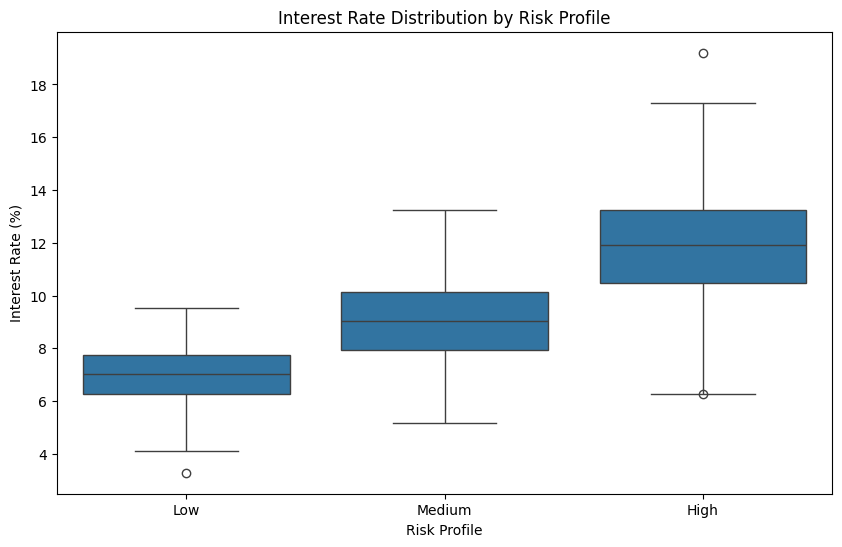

In [80]:
# EDA: Visualizing interest rate distribution by risk profile
plt.figure(figsize=(10, 6))
sns.boxplot(x='RiskProfile', y='InterestRate', data=loan_data)
plt.title('Interest Rate Distribution by Risk Profile')
plt.xlabel('Risk Profile')
plt.ylabel('Interest Rate (%)')
plt.show()


In [81]:
# Analyzing default rates across risk profiles
default_rates = loan_data.groupby('RiskProfile')['Default'].mean()
print("\nDefault Rates by Risk Profile:")
print(default_rates)


Default Rates by Risk Profile:
RiskProfile
High      0.350000
Low       0.051980
Medium    0.143939
Name: Default, dtype: float64


In [82]:
# Logistic Regression: Modeling default probability
X = loan_data[['InterestRate', 'LoanAmount', 'Income']]
y = loan_data['Default']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)


In [83]:
# Check class distribution before undersampling
print("\nClass Distribution Before Undersampling:")
print(y_train.value_counts())

# Apply Random Undersampling
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

# Check class distribution after undersampling
print("\nClass Distribution After Undersampling:")
print(y_resampled.value_counts())


Class Distribution Before Undersampling:
Default
0    596
1    104
Name: count, dtype: int64

Class Distribution After Undersampling:
Default
0    104
1    104
Name: count, dtype: int64


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


In [84]:
# Train the logistic regression model
log_reg = LogisticRegression()
log_reg.fit(X_resampled, y_resampled)

# Predict on the test set
y_pred = log_reg.predict(X_test)
y_pred_proba = log_reg.predict_proba(X_test)[:, 1]

In [85]:
# Evaluate the model
print("\nClassification Report After Undersampling:")
print(classification_report(y_test, y_pred))

# AUC-ROC Score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"\nAUC-ROC Score: {roc_auc:.4f}")


Classification Report After Undersampling:
              precision    recall  f1-score   support

           0       0.91      0.71      0.80       256
           1       0.27      0.61      0.37        44

    accuracy                           0.70       300
   macro avg       0.59      0.66      0.59       300
weighted avg       0.82      0.70      0.74       300


AUC-ROC Score: 0.6884


In [86]:
# Define risk profile scenarios
risk_profiles = ['Low', 'Medium', 'High']
simulated_defaults = []

for profile in risk_profiles:
    # Generate interest rates for the given profile
    profile_data = loan_data[loan_data['RiskProfile'] == profile]
    simulated_interest_rates = np.random.normal(
        loc=profile_data['InterestRate'].mean(),
        scale=profile_data['InterestRate'].std(),
        size=1000
    )

    # Simulate default probabilities
    for rate in simulated_interest_rates:
        X_sim = pd.DataFrame({
            'InterestRate': [rate],
            'LoanAmount': [X['LoanAmount'].mean()],
            'Income': [X['Income'].mean()]
        })
        sim_default = log_reg.predict_proba(X_sim)[:, 1]
        simulated_defaults.append((profile, rate, sim_default[0]))

# Convert simulation results to a DataFrame
simulated_results = pd.DataFrame(simulated_defaults, columns=['RiskProfile', 'InterestRate', 'DefaultProbability'])

<ipython-input-87-4d38bbfd6180>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


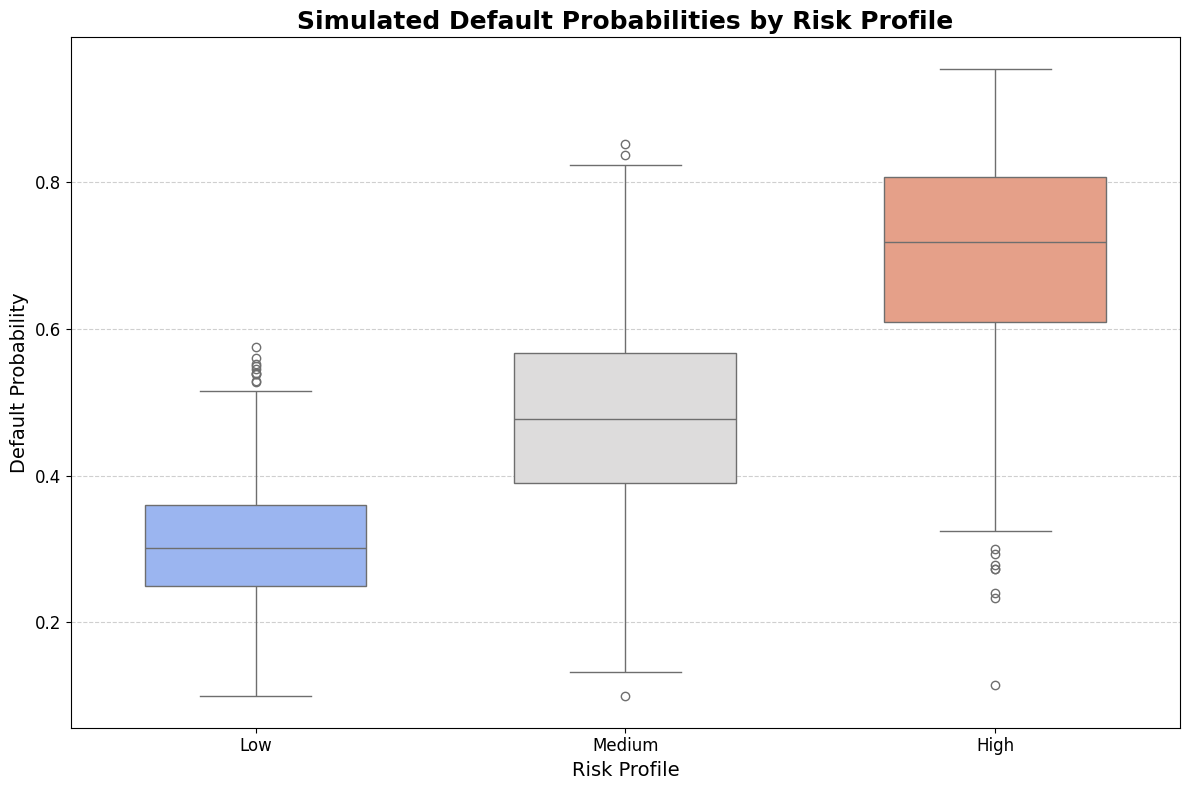

In [87]:
#Create the visualization of the results

plt.figure(figsize=(12, 8))

# Create the boxplot
sns.boxplot(
    x='RiskProfile',
    y='DefaultProbability',
    data=simulated_results,
    palette='coolwarm',
    width=0.6
)

# Add titles and labels
plt.title('Simulated Default Probabilities by Risk Profile', fontsize=18, weight='bold')
plt.xlabel('Risk Profile', fontsize=14)
plt.ylabel('Default Probability', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add a grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plot
plt.show()



# Highlights
1**. Low-Risk Profile:**
* Low Default Probability: The default probabilities are concentrated in a lower range with a relatively narrow interquartile range (IQR), indicating stability and predictability in repayment behavior.
* Few Outliers: The outliers indicate rare cases of higher default probabilities, which may require minimal intervention or targeted analysis.

**2. Medium-Risk Profile:**
* Moderate Default Probability: The default probabilities have a wider IQR, showing higher variability compared to the low-risk group.
* Higher Median: The median default probability is higher than the low-risk group, suggesting a higher likelihood of defaults in this category.
* A Few Low Outliers: Rare cases of borrowers with lower default probabilities despite being categorized as medium risk.

**3. High-Risk Profile:**
* High Default Probability: The default probabilities show the widest range and the highest median, reflecting significant risk associated with this group.
* Significant Spread: The data has a wide IQR, indicating diverse repayment behaviors within this group.
* Unusual Low Outliers: Some borrowers in this category demonstrate low default probabilities, which could indicate exceptional repayment behavior or misclassification.


---


**Recommendations**

**1. Low-Risk Borrowers:**
* Expand Lending: Focus on increasing loan approvals for this group to capitalize on their stable repayment behavior.
* Incentivize Loyalty: Introduce rewards programs such as lower interest rates or faster loan processing to retain and attract low-risk borrowers.

**2. Medium-Risk Borrowers:**
* Monitor Closely: Develop monitoring tools to identify early warning signs of potential defaults within this group.
* Personalized Repayment Options: Provide flexible repayment plans or partial repayment options to reduce default probabilities.
* Risk Reassessment: Use updated data or machine learning models to reassess the risk profile and adjust strategies accordingly.

**3. High-Risk Borrowers:**
* Tighten Eligibility: Restrict loan approvals for high-risk borrowers or require collateral to minimize financial exposure.
* Focused Support: Offer financial education or counseling programs to help these borrowers improve their repayment capacity.
* Dynamic Pricing: Introduce higher interest rates or other compensatory measures to offset the higher default risk.

**4. Overall Strategies:**
* Portfolio Optimization: Diversify the loan portfolio to include a higher proportion of low- and medium-risk borrowers while minimizing exposure to high-risk borrowers.
* Enhanced Risk Modeling: Implement advanced machine learning models to dynamically update risk profiles and improve classification accuracy.
* Outlier Analysis: Investigate outliers in the high- and medium-risk categories to identify factors driving lower default probabilities.

These recommendations aim to optimize lending strategies, reduce default rates, and enhance the financial performance of the loan portfolio.















# Recommendations for Model Evaluation Improvements
1. Increase Recall for Class 1 (Default):

* The model captures 61% of actual defaults, but this can be improved:
  * Implement SMOTE or Oversampling: Balance the dataset by synthetically generating more instances of Class 1 to help the model learn better patterns for defaults.
  * Cost-Sensitive Learning: Penalize the model more heavily for misclassifying defaults to increase recall.

2. Improve Precision for Class 1 (Default):
* A precision of 27% indicates too many false positives (non-defaults classified as defaults):
  * Feature Selection/Engineering: Identify and use additional features that differentiate defaults and non-defaults more effectively.
  * Threshold Tuning: Adjust the decision threshold for predicting Class 1 to reduce false positives without significantly lowering recall.

3. Boost F1-Score for Class 1:
* The F1-score for Class 1 is low (0.37) due to the tradeoff between precision and recall:
  * Use Ensemble Models: Try algorithms like Random Forest or XGBoost that can better handle imbalanced datasets and improve F1-scores.
  * Cross-Validation: Perform cross-validation to fine-tune the model and ensure consistency in balancing precision and recall.

4. Enhance Overall AUC-ROC Score:
* An AUC-ROC of 0.6884 is moderate and indicates room for improvement in distinguishing between classes:
  * Hyperparameter Tuning: Optimize model parameters to improve the separation of the two classes.
  * Experiment with Advanced Models: Use gradient boosting or neural networks to achieve better performance in complex datasets.

5. Increase Macro Average Metrics:
* The macro average for precision (0.59) and F1-score (0.59) reflects poor performance on the minority class:
  * Data Augmentation: Create synthetic datasets or generate more diverse training samples to strengthen minority class predictions.
  * Analyze Misclassifications: Study incorrectly classified cases to identify gaps in the model's ability to learn class boundaries.

6. Evaluate Weighted Metrics for Business Relevance:
* Weighted averages are skewed toward the majority class, which may not align with business objectives:
  * Business-Driven Metrics: Use evaluation metrics like cost matrices to quantify the financial impact of false positives and false negatives, and tune the model accordingly.
  * Custom Evaluation Metrics: Define domain-specific metrics (e.g., financial loss minimization) to align model optimization with business goals.
